# Figure with multiple AXES setup in a loop!

# Cananéia/SP - longitudinal survey of CTD

### CTD JFE-Rinko + GPS

### Depth trigger / software Infinity SDlogger

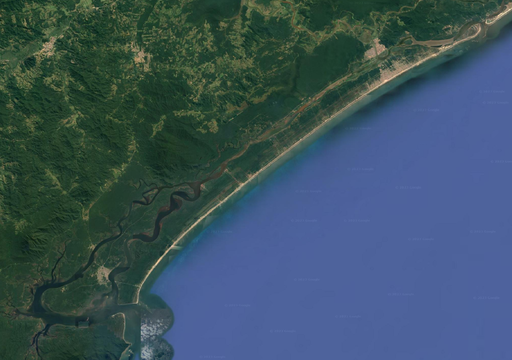

In [1]:
import os
from dateutil.parser import parse
import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import griddata

### Load the CTD data, and make it ready to work... do it 1x, and after check it works fine, create a funcion to run the batch!

In [2]:
ctd_path = r'd:\GUTO\1_Trabs\1_Aestus\Cananeia\Curso_201812\CTD_longitudinal\csv\\'

fdir = os.listdir(ctd_path)

with open(ctd_path + fdir[0]) as io:
    lines = io.read().splitlines()
    
trigger = 0
data = []
for i, li in enumerate(lines):
    if 'StartTime' in li:
        liq = li.split('=')
        time = parse(liq[1])
        
    if 'Depth [m],Temp. [deg C]' in li:
        header = li.split(',')
        trigger = 1
        continue
        
    if trigger == 1:
        liq = li.split(',')
        li_data = [np.float64(x) for x in liq[:-1]]
        data.append(li_data)

data = np.array(data)
data.shape

(80, 13)

In [3]:
def JFE_Rinko_SDlogger_Depth(lines):
    
    trigger = 0
    data = []
    for i, li in enumerate(lines):
        if 'StartTime' in li:
            liq = li.split('=')
            time = parse(liq[1])

        if 'Depth [m],Temp. [deg C]' in li:
            header = li.split(',')
            trigger = 1
            continue

        if trigger == 1:
            liq = li.split(',')
            li_data = [np.float64(x) for x in liq[:-1]]
            data.append(li_data)

    data = np.array(data[:-3]) # eliminates the last 0.3 m!
    data.shape
    
    return time, header, data

In [4]:
g_time = []
g_data = []
g_depth = []

for f in fdir:
    with open(ctd_path + f) as io:
        lines = io.read().splitlines()
        
    time, header, data =  JFE_Rinko_SDlogger_Depth(lines)
    
    g_depth.append(np.max(data[:,0])) # get the depth of the profile
    g_time.append(time)
    g_data.append(data)

In [5]:
for i, h in enumerate(header):
    print(i, h)

0 Depth [m]
1 Temp. [deg C]
2 Sal. [ ]
3 Cond. [mS/cm]
4 EC25 [uS/cm]
5 Density [kg/m^3]
6 SigmaT [ ]
7 Chl-Flu. [ppb]
8 Chl-a [ug/l]
9 Turb-M [FTU]
10 DO [%]
11 DO [mg/l]
12 Batt. [V]
13 


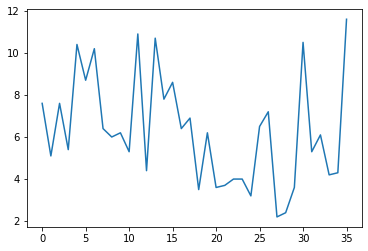

In [6]:
plt.plot(g_depth)

In [7]:
# junta = [g_time, header, data]
# with open('CTD_Cananeia_longitudinal.pkl', 'wb') as io:
#     pickle.dump(junta, io)

## Load GPS

During the survey we marked the points of every cast, but forgot some... so here I just interpolate to make it easier...

In [8]:
with open('GPS_cananeia.pkl', 'rb') as io:
    gps = pickle.load(io)
    
gps_time = gps[:,0] - datetime.timedelta(hours=3)
longitude = gps[:,1]
latitude = gps[:,2]

gps_time_n = mdates.date2num(gps_time)

In [9]:
ctd_time = np.array(g_time)
ctd_time_n = mdates.date2num(ctd_time)

longitude = np.array(longitude, dtype='float64')
latitude = np.array(latitude, dtype='float64')

loni = np.interp(ctd_time_n, gps_time_n, longitude)
lati = np.interp(ctd_time_n, gps_time_n, latitude)

In [10]:
print(len(ctd_time), len(gps_time_n))

36 49


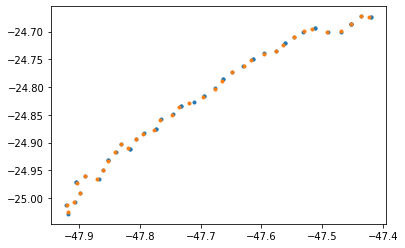

In [11]:
plt.plot(longitude, latitude, '.')
plt.plot(loni, lati, '.')

In [12]:
# to be used in Qgis
# lonlat = np.hstack((
#                     np.atleast_2d(loni).T,
#                     np.atleast_2d(lati).T
#                     ))

# np.savetxt('Cananeia_estacoes_longitudinal.txt', lonlat, delimiter=',')

# this was stupid! Best doing:
# LonLat = np.vstack((Loni, Lati)).T   # living and learning...

### Calculating the distance along the survey

1 degree = 111.12 km!

In [13]:
dif_dist = (np.diff(loni)**2 + np.diff(lati)**2)**.5 * 111.12
dist = np.cumsum(dif_dist)

# to start at 0, and have the same N of depths!
dist = np.insert(dist, 0, 0)

### And create and array of the distances for each level of CTD's measurement

In [14]:
x = []
joint = []           
for i, d in enumerate(g_data):
    
    x = x + np.linspace(dist[i], dist[i], len(d)).tolist()

    joint = joint + d.tolist()
    
joint = np.array(joint)
x = np.array(x)

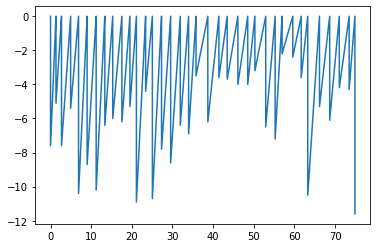

In [15]:
plt.plot(x, -joint[:,0])

### Creating the mask to indicate the 'bottom'

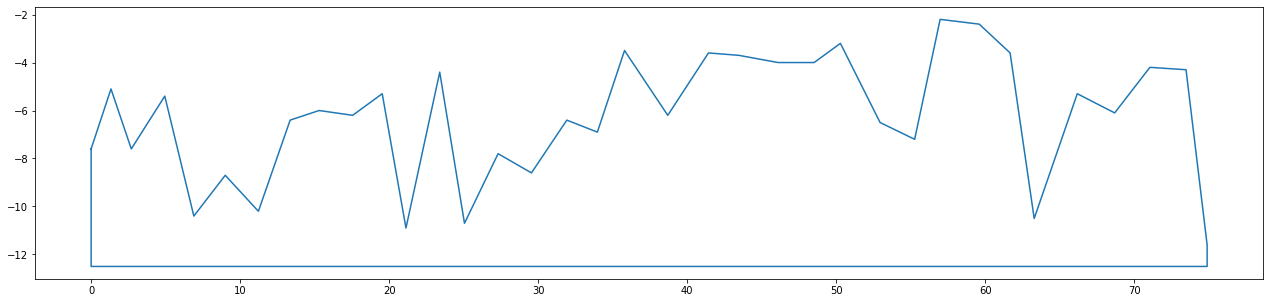

In [19]:
mask_x = np.copy(dist)
mask_z = -np.array(g_depth)

maxz = -12.5

# to close the polygon
comp_x = np.array([np.max(x), np.min(x), np.min(x)])
comp_z = np.array([maxz, maxz, mask_z[0]])

mask_x = np.concatenate((mask_x, comp_x))
mask_z = np.concatenate((mask_z, comp_z))

plt.figure(figsize=(22,5))
plt.plot(mask_x, mask_z)

### Interpolating...

In [22]:
points = np.hstack((
                    np.atleast_2d(x).T,
                    np.atleast_2d(joint[:,0]).T * -1
                    ))

xi = np.linspace(np.min(dist), np.max(dist), 100)
zi = np.linspace(-13, -0.5, 50)

xx, zz = np.meshgrid(xi, zi)

sal_i = griddata(points, joint[:,2], (xx, zz), method='linear' )
temp_i = griddata(points, joint[:,1], (xx, zz), method='linear')
turb_i = griddata(points, joint[:,9], (xx, zz), method='linear')
clor_i = griddata(points, joint[:,8], (xx, zz), method='linear')
ox_i = griddata(points, joint[:,10], (xx, zz), method='linear')

dists = [sal_i, temp_i, np.log(turb_i), np.log(clor_i), ox_i]

#### Checking...

Text(0.5, 0, 'Distance (km)')

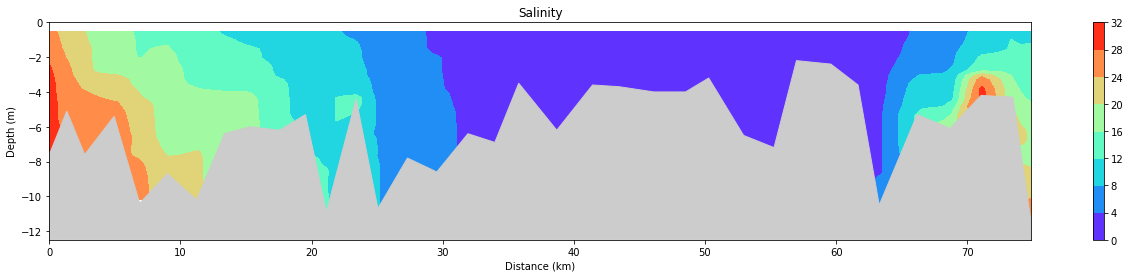

In [24]:
plt.figure(figsize=(22,4))
cb=plt.contourf(xi, zi, sal_i, cmap='rainbow')
plt.colorbar()
plt.fill(mask_x, mask_z, color=[.8,.8,.8])
plt.ylim(-12.5, 0)
plt.title('Salinity')
plt.ylabel('Depth (m)')
plt.xlabel('Distance (km)')

### Grand finale...

Create the final figura, but this time I create the axes in a loop... much cleaner way!

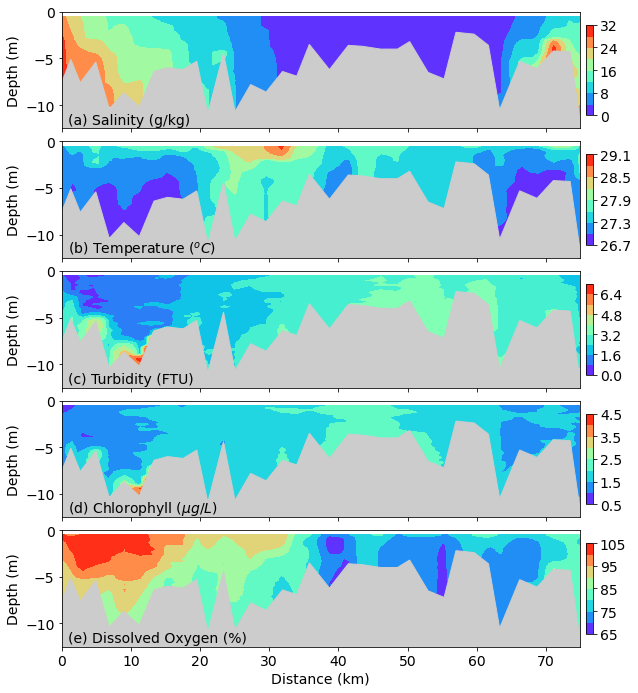

In [32]:
plt.rcParams.update({'font.size':14})
variables = ['(a) Salinity (g/kg)', '(b) Temperature ($^oC$)', '(c) Turbidity (FTU)', '(d) Chlorophyll ($\mu g/L$)', '(e) Dissolved Oxygen (%)']

fig = plt.figure(figsize=(9,9))

# axis positions
px = .1
py = .8
dx = .8
dy = .18
dint = .02

# colorbar positions
pxcb = px + dx + 0.01
dxcb = 0.01
fc = .02 # to reduce it a little

axs = []
cbaxs = []
for i in range(5):
    # create the axes
    axs.append( 
                fig.add_axes( [px, py-(dy+dint)*i, dx, dy] )
                )
    # create the colorbar axes  
    cbaxs.append(
                fig.add_axes( [pxcb, py-(dy+dint)*i+fc, dxcb, dy-fc*2] )
                )

    cb = axs[i].contourf(xi, zi, dists[i], cmap='rainbow')
    axs[i].fill(mask_x, mask_y, color=[.8,.8,.8])
    
    cbar = plt.colorbar(cb, cax=cbaxs[i])
    cbar.ax.locator_params(nbins=5)
    
    axs[i].set_ylabel('Depth (m)')
    axs[i].set_ylim(-12.5, 0)
    axs[i].text(1, -12, variables[i])
    
    if i < 4:
        axs[i].set_xticklabels('')
    if i == 4:
        axs[i].set_xlabel('Distance (km)')
    